### **Required Libraries and Imports**


##### Imports

In [1]:
# general imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import date

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
from yellowbrick.cluster import KElbowVisualizer

from sklearn.metrics import silhouette_samples, silhouette_score

from fcmeans import FCM

import umap.umap_ as umap
import hdbscan

from utils.utils_cluster import *
np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

C:\Python\Anaconda\envs\ML2\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Python\Anaconda\envs\ML2\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Python\Anaconda\envs\ML2\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopyth

<br><br>

## **Data Acquisition**

<br>
As performed in the previous notebook, the data is imported using a pandas function called 'read_csv'. This function utilizes the path held in the variable in the cell below, indicating the specific location where the data is stored. The respective dataset is stored in 'info' and corresponds to the modified data set exported at the end of the EDA notebook

In [2]:
path = "./data/"
info = pd.read_csv(path + "eda_info.csv")

<br>

To check the amount of missing values present in the imported data set, two methods are used, `.isnull` and `.sum`. This allows us to see how many missing values each column in the `` info'' dataframe contains.

In [3]:
info.isnull().sum()

customer_id                                0
customer_name                              0
customer_gender                            0
number_complaints                          0
distinct_stores_visited                    0
lifetime_spend_groceries                   0
lifetime_spend_electronics                 0
typical_hour                               2
lifetime_spend_vegetables                  0
lifetime_spend_nonalcohol_drinks           0
lifetime_spend_alcohol_drinks              0
lifetime_spend_meat                        0
lifetime_spend_fish                        0
lifetime_spend_hygiene                     0
lifetime_spend_videogames                  0
lifetime_total_distinct_products           0
percentage_of_products_bought_promotion    0
latitude                                   0
longitude                                  0
years_as_customer                          0
customer_age                               0
education                                  0
has_child 

The output above displays that the column 'typical_hour' is the only one in the data that contains missing values, more specifically, two.



To perform clustering analysis we cannot have missing values in the data, therefore, 'info' is divided into two different data sets below, 'missing_typical_hour' and 'info'. The first one, 'missing_typical_hour', consists of the two observations in which 'typical_hour' had missing values, whereas 'info' contains the remaing observations.

In [4]:
missing_typical_hour = info[info['typical_hour'].isna()]
info = info.dropna(subset = ['typical_hour'])

To confirm that the new 'info' dataset is reduced in two rows and does not contain missing values, the procedure to check for missing values in the data is conducted, followed by the `.shape` method, used to display the shape of the data set.

In [5]:
print(info.isnull().sum(),'\n\n' ,'Shape:\n', info.shape)

customer_id                                0
customer_name                              0
customer_gender                            0
number_complaints                          0
distinct_stores_visited                    0
lifetime_spend_groceries                   0
lifetime_spend_electronics                 0
typical_hour                               0
lifetime_spend_vegetables                  0
lifetime_spend_nonalcohol_drinks           0
lifetime_spend_alcohol_drinks              0
lifetime_spend_meat                        0
lifetime_spend_fish                        0
lifetime_spend_hygiene                     0
lifetime_spend_videogames                  0
lifetime_total_distinct_products           0
percentage_of_products_bought_promotion    0
latitude                                   0
longitude                                  0
years_as_customer                          0
customer_age                               0
education                                  0
has_child 

It is observed that there are no missing values in the data and the amount of rows is now 29998, given that the initial number of rows was 30000.

<br><br>
## **Feature Scaling**

<br>

To perform clustering techniques, it is necessary to first scale the data, since most of them is based on distances. Thus, the data 'info' will be anew divided in to different data sets, 'data_to_scale' and 'data_not_scaled'. As the names suggest, 'data_not_scaled' is the data that will not be scaled, whereas 'data_to_scale' is the data that will be scaled, and therefore, included in the clustering procedures. The data that will not be used in the clustering section, will be considered in following stages for analysis purposes.

In [7]:
data_to_scale = info.drop(['customer_id', 'customer_name', 'customer_gender', 'education', 'has_loyalty_card', 'has_child', 'latitude', 'longitude'], axis=1)
data_not_scaled = info.drop(data_to_scale.columns, axis=1)

<br>

To effectively scale the data, two scalers are used, MinMaxScaler and StandardScaler. Eventually, the one that provides a better cluster distribution and interpretability, will be chosen.

In [8]:
mm_scaler = MinMaxScaler()
mm_scaled_data = mm_scaler.fit_transform(data_to_scale)

st_scaler = StandardScaler()
st_scaled_data = st_scaler.fit_transform(data_to_scale)

<br><br><br>


## **Clustering Techniques**

<br>

### **1. DBSCAN**

The first segmentation implemented is performed by the DBSCAN. This implementation is conducted using the function `DBSCAN` with the parameters `eps = 2` and `min_samples = 50` and applying it to the scaled data. The `eps`, i.e., maximum distance between two points for them to be considered as neighbors, is defined as two units. The `min_samples` is set to fifty, which means that a cluster must contain at least fifty data points (including the core point) to be considered a valid cluster. These parameters were selected after some testing procedures, in which it was noted that changes in `eps` resulted in significant variations of the amount of observations considered as outliers, i.e., the ones included in cluster -1. Hence, this clustering method does not seem optimal for this data, as it does not exhibit consistency. 

In [9]:
cluster_dbscan = DBSCAN(eps=2, min_samples=50).fit_predict(st_scaled_data)
info["cluster_dbscan"] = cluster_dbscan

To be able to compare the different segmentations performed in this notebook, the information about each of theirs clusters' size is stored. In this case, the size of each cluster for the DBSCAN is stored in the variable 'dbscan_size'

In [10]:
dbscan_size = info.groupby("cluster_dbscan").size().to_frame()
dbscan_size.columns = ["dbscan_size"]

For a more intuitive visualization of the distribution of the clusters, it is used the function `plot_clusters` on the DBSCAN clusters.

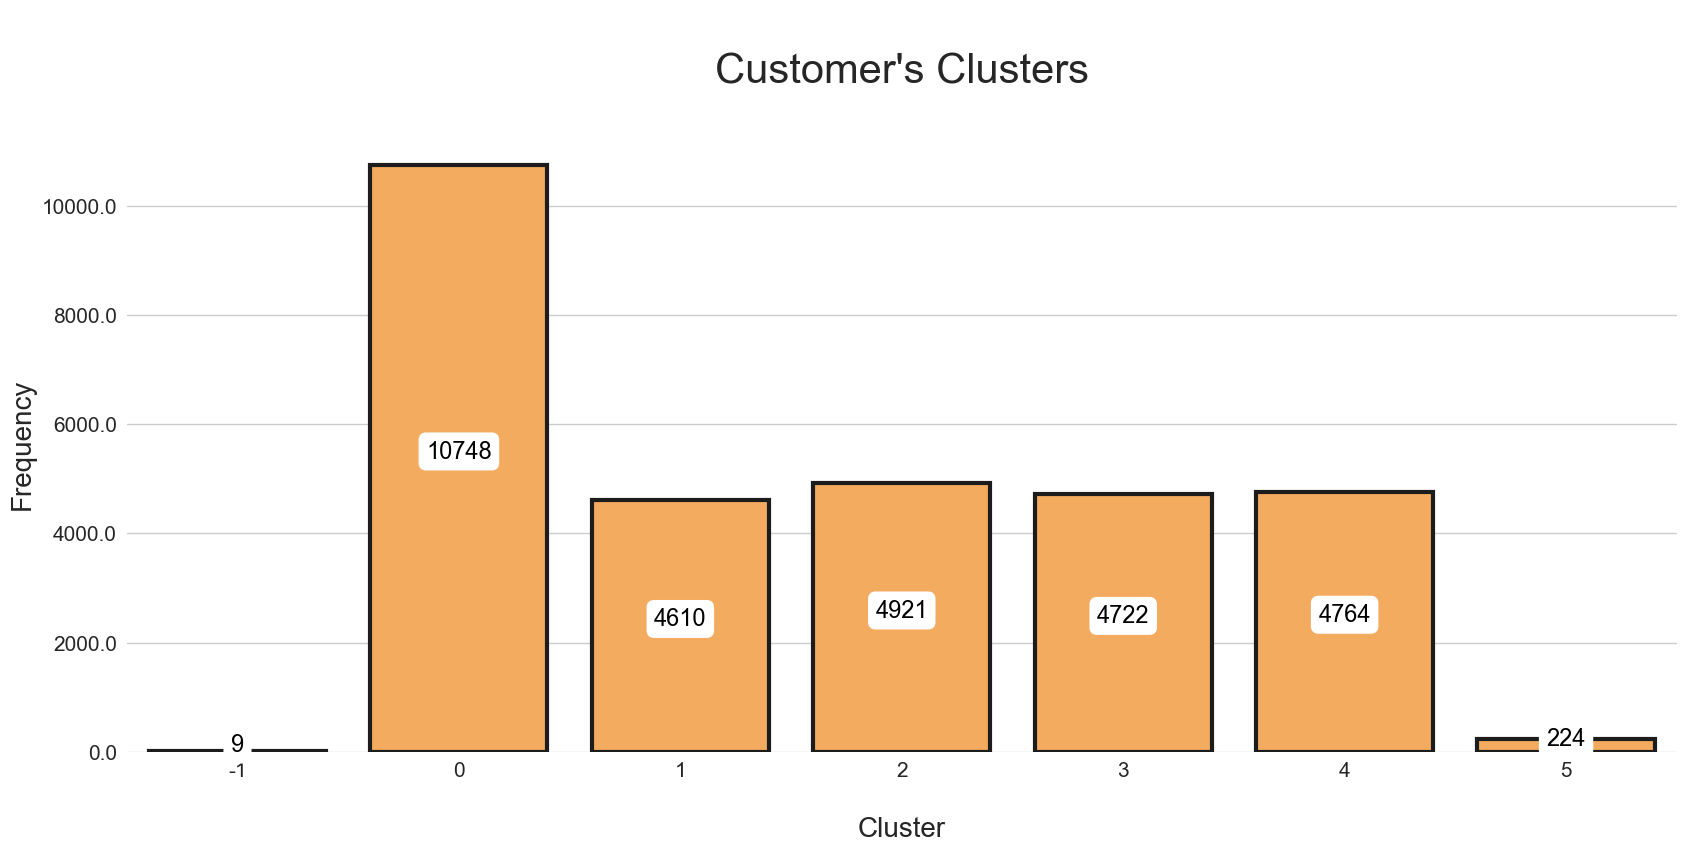

In [11]:
plot_clusters(info["cluster_dbscan"])

It is noted that the first cluster (the one denoted as -1) is composed by the observations that the DBSCAN considered outliers, only containing nine observations. The remaing observations are not uniformly distributed among the five clusters, since the cluster zero is composed by a large amount of observations, while cluster five has solely 224. 

<br>

As the final visualization tool for the DBSCAN clusters, UMAP will be used. UMAP can provide a more interpretable representation of the clustered data. By reducing dimensionality and visualizing the data in a lower dimensional space, it is possible to better understand the relationships between the clusters, detect any overlaps or separations, and gain insight into the underlying structure of the data.

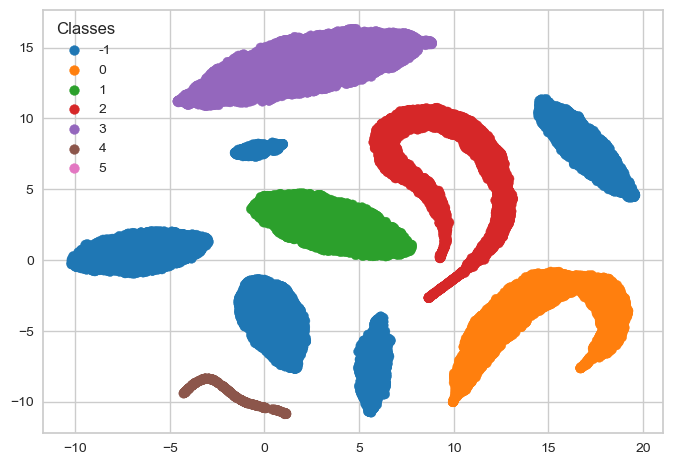

In [12]:
data_umap = info.drop(data_not_scaled.columns, axis=1).sort_index()

_ = umap_visual(data_umap, info["cluster_dbscan"].sort_index())

In the output image above, it can be seen that DBSCAN delimits each cluster well, with only the one that contains outliers being scattered.However, as mentioned previously, this method has proven not to be consistent. 

The results provided by this clustering technique will be removed from the 'info' data set in the next cell, to ensure that they do not interfere with the following phases.

In [13]:
info = info.drop("cluster_dbscan", axis =1)

<br><br>

### **2. Fuzzy CMeans**

Fuzzy CMeans (FCM) is a clustering algorithm that extends K-means by assigning fuzzy membership values to data points, indicating their degree of membership in clusters. FCM iteratively updates the centers and cluster members until convergence. Prior to running the algorithm, we will take into account the fuzzy partition coefficient (FPC), which will be useful for choosing the optimal number of clusters.

The function cmeans_fpc it is used for the purpose of choosing the optimal number of clusters. This function calculates the fuzzy partition coefficient (FPC), such that it provides a way to visualize the relationship between the number of clusters and the corresponding FPC values.

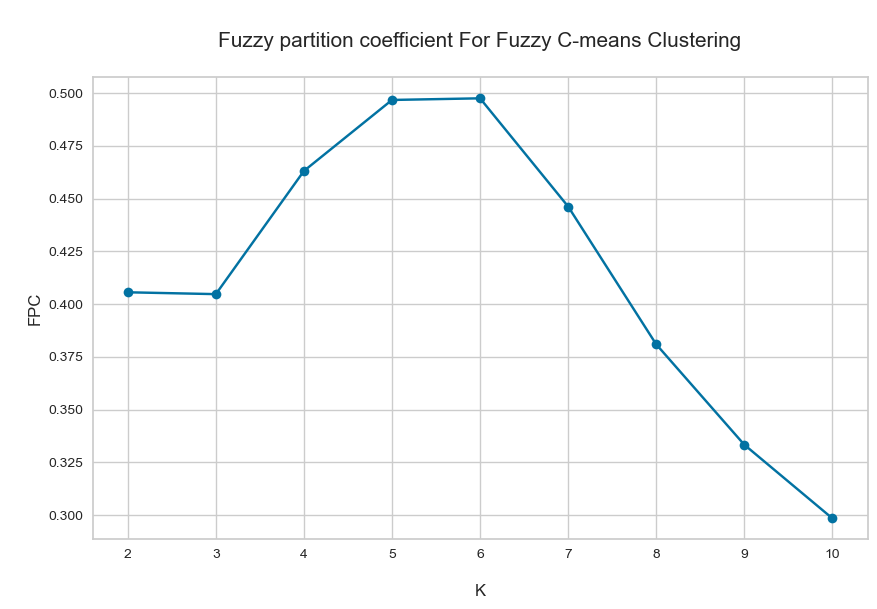

In [14]:
cmeans_fpc(st_scaled_data)

Since a higher FPC value suggests that the membership values are more distinct and well-separated, the number of clusters chosen through the visualization of the output graphic above is six clusters. 

It is then, in the code below, executed the FCM for six clusters, on the respective scaler data, and stored as a column in 'info'.

In [15]:
fcm_solution = FCM(n_clusters=6, random_state=42)
fcm_solution.fit(st_scaled_data)

In [16]:
cluster_fcm= fcm_solution.predict(st_scaled_data)
info['cluster_fcm'] = cluster_fcm

As mentioned before, the values of the size of each cluster are stored for future comparisons. In this case they are stored in the variable 'cluster_fm'. 

In [17]:
fmc_size = info.groupby("cluster_fcm").size().to_frame()
fmc_size.columns = ["fmc_size"]

To visualize the distribution of the FCM clusters, it is used the function `plot_clusters`. 

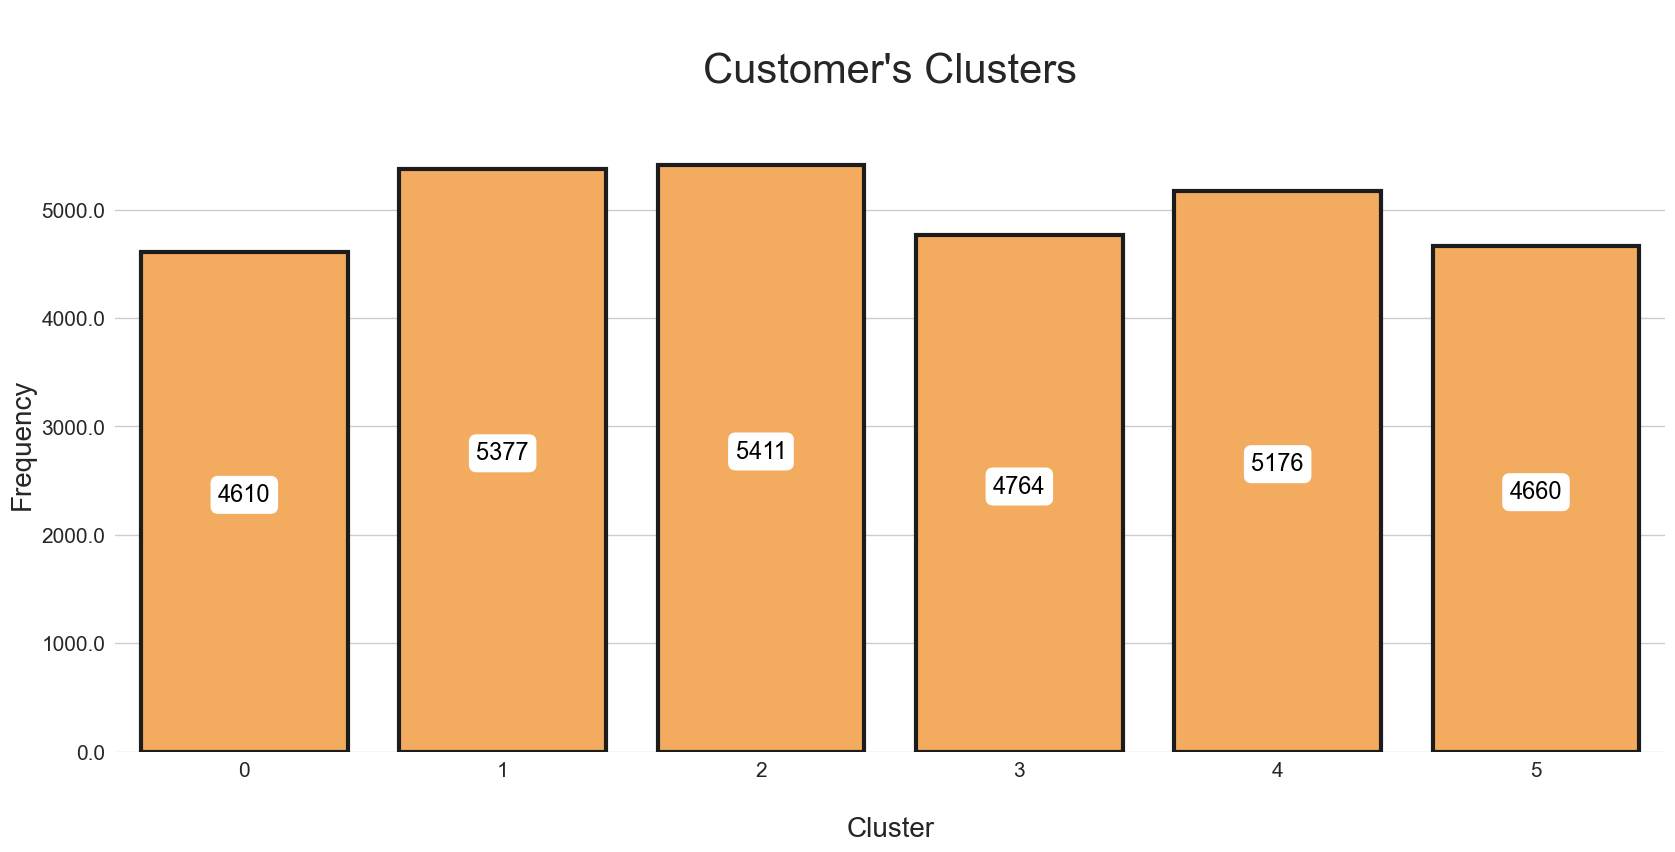

In [18]:
plot_clusters(info["cluster_fcm"])

It is observed by the output image, that the distribution of the FCM clusters is significantly different from the ones in the DBSCAN. In this case, the clusters have somewhat similar sizes.

For visualization purposes, UMAP is used below. 

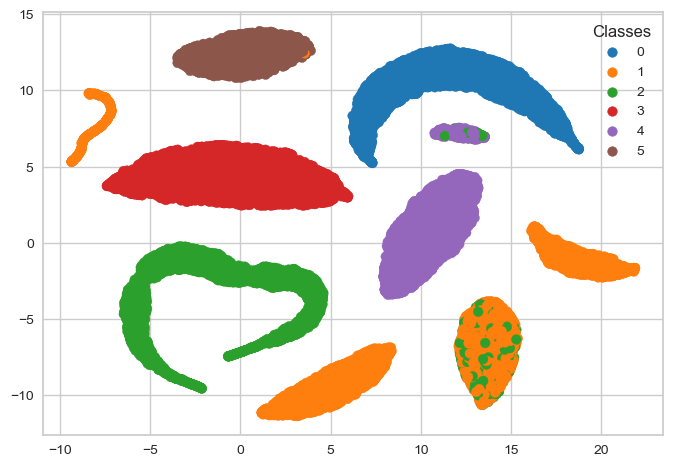

In [19]:
data_umap = info.drop(data_not_scaled.columns, axis=1).sort_index()
_ = umap_visual(data_umap, info["cluster_fcm"].sort_index())

The UMAP resulting image above suggests that the FCM clusters are not as well defined as the ones from DBSCAN. There are clusters that have individuals which seem to be closer to individuals of other clusters, such as cluster two.

The cluster of this segmentation will also be removed from the 'info' data set. However, it will be considered in further steps for means of comparison.

In [20]:
info = info.drop("cluster_fcm", axis =1)

<br><br>


### **3. K-means**

K-means is a widely used clustering algorithm that divides a data set into K clusters by iteratively assigning data points to clusters based on the proximity of the centers of the clusters. The goal of the algorithm is to minimize the sum of the squared distances. This algorithm will be applied to the data scaled by the MinMax and the standard scaler.

To choose the optimal K value, i.e., the optimal number of clusters, it is used the plot of the elbow curve that shows the relationship between the number of clusters (K) and the corresponding distortion scores. The optimal K will be defined by the point where the rate of improvement in distortion scores diminishes significantly, indicating a reasonable trade-off between cluster quality and complexity.

##### **A. Using MinMaxscaler**

The function `kmeans_elbow` is applied on the MinMax scaled data, to plot the elbow curve. 

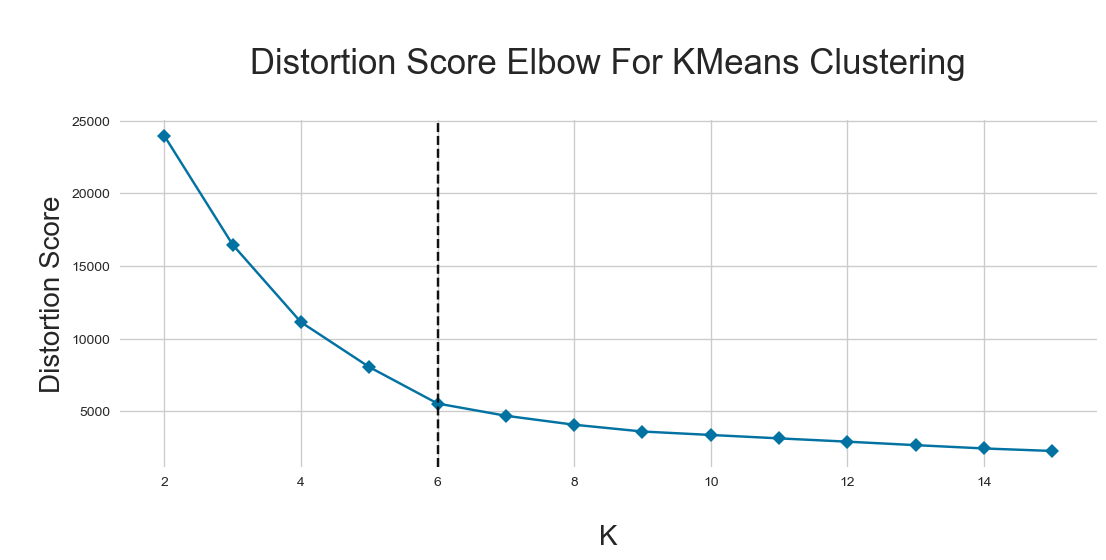

In [21]:
kmeans_elbow(mm_scaled_data)

The plot above displays clearly that the optimal K is seven, i.e., six clusters. Therefore, the `KMeans` function is executed with the parameter `n_clusters = 6` and stored in 'info'.

In [22]:
kmeans_solution_mm = KMeans(n_clusters=6, random_state=42).fit(mm_scaled_data)
cluster_kmeans_mm = kmeans_solution_mm.predict(mm_scaled_data)

info['cluster_kmeans_mm'] = cluster_kmeans_mm

To visualize the distribution of the K-means clusters it is used the function `plot_clusters`.

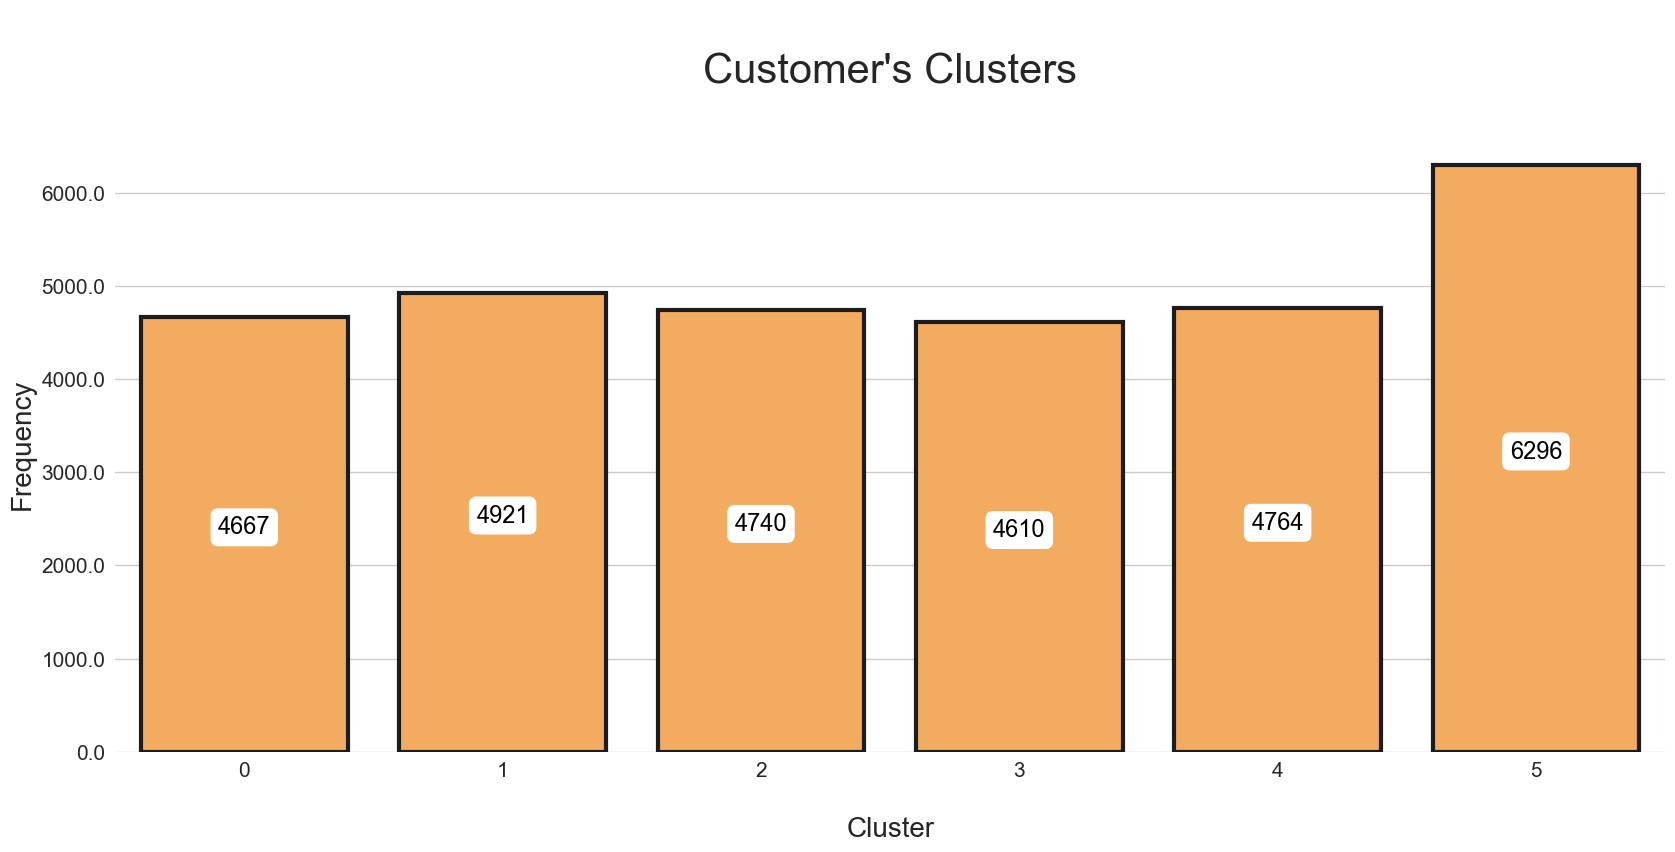

In [23]:
plot_clusters(info["cluster_kmeans_mm"])

The output images shows that the cluster sizes differ a lot among each other as well as for the results given by all the previous implmentations, i.e, K-means with standard scaled data, FCM and DBSCAN.


As an extra visualization tool to analyse the definition of each cluster, it is used the `plot_silhouette` function. This function calculates and generates a silhouette graph with filled areas representing the silhouette values of the clusters, along with the average silhouette score shown as a red dashed line. The silhouette values are a measure of how well each data point fits within its assigned cluster in a clustering solution.

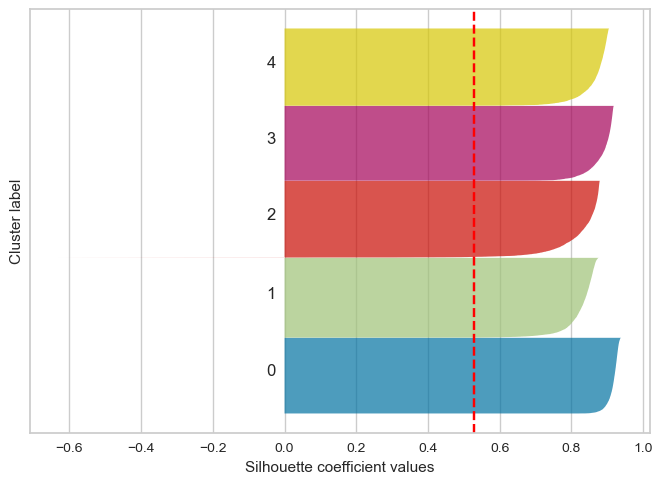

In [24]:
plot_silhouette(data_to_scale,kmeans_solution_mm, 5)

The output image above suggests that the clusters of the MinMax scaled data are well defined.

As a final visualization, the UMAP is used to access the definition of each cluster. 

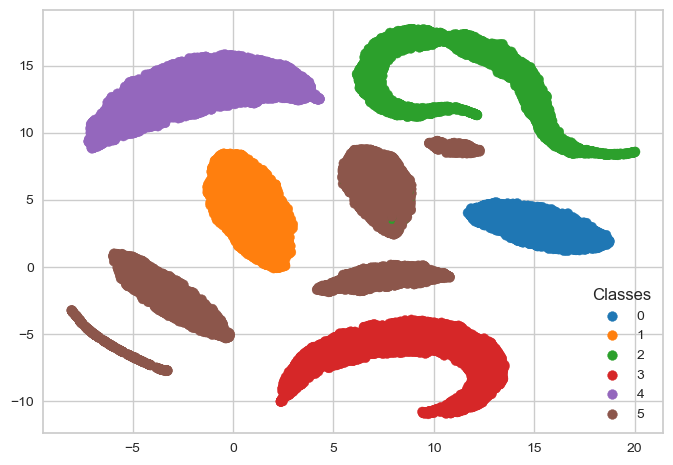

In [25]:

data_umap_mm = info.drop(data_not_scaled.columns, axis=1).sort_index()
data_umap_mm = data_umap_mm.drop(["cluster_kmeans_mm"], axis=1).sort_index()

embedding_mm = umap_visual(data_umap_mm, info["cluster_kmeans_mm"].sort_index(), 15, 0.3, 42)

The output image above indicates that the K-mean clusters with MinMax scaled data are well defined, in the sense that are not much visible observations that seem to be in the wrong cluster. However, the observations in cluster five are quite disperce, which may suggest a fairly poorly defined cluster.

The information about each cluster size is stored in 'kmeans_size_mm' for future comparisons.

In [26]:
kmeans_size_mm = info.groupby("cluster_kmeans_mm").size().to_frame()
kmeans_size_mm.columns = ["kmeans_size_mm"]

The results provided by this first K-means will be removed from the 'info' data set in the next cell, to ensure that they do not interfere with the following phases.

In [27]:
info = info.drop(["cluster_kmeans_mm"], axis =1)

##### **B. Using standard scaler**

The function `kmeans_elbow` is applied on the standard scaled data, to plot the elbow curve. 

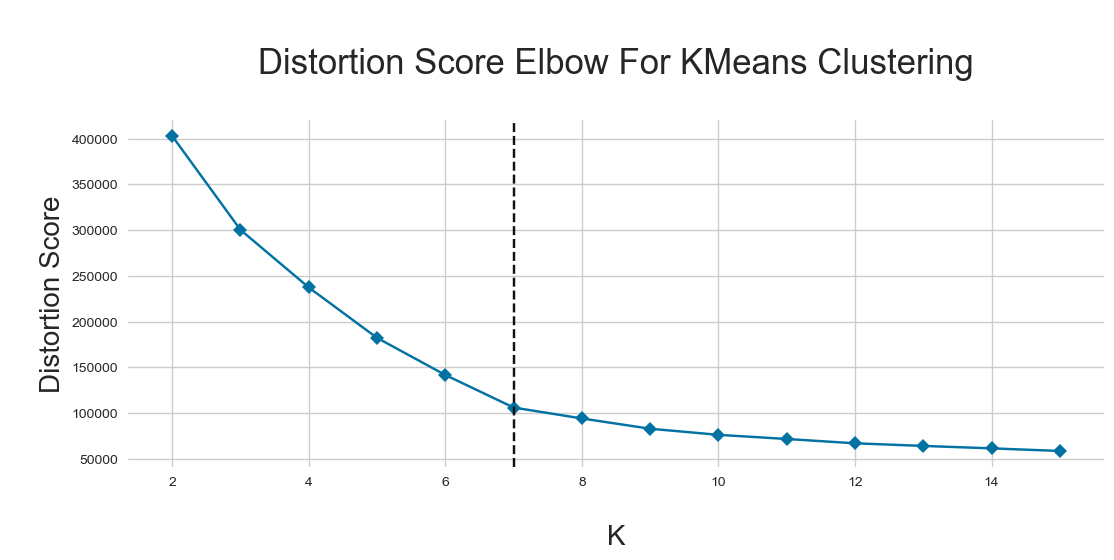

In [28]:
kmeans_elbow(st_scaled_data)

The plot above displays clearly that the optimal K is seven, i.e., seven clusters. Therefore, the `KMeans` function is executed with the parameter `n_clusters = 7` and stored in 'info'. 

In [29]:
kmeans_solution_st = KMeans(n_clusters=7, random_state=42).fit(st_scaled_data)
cluster_kmeans_st = kmeans_solution_st.predict(st_scaled_data)
info['cluster_kmeans_st'] = cluster_kmeans_st

To visualize the distribution of the K-means clusters it is used the function `plot_clusters`.

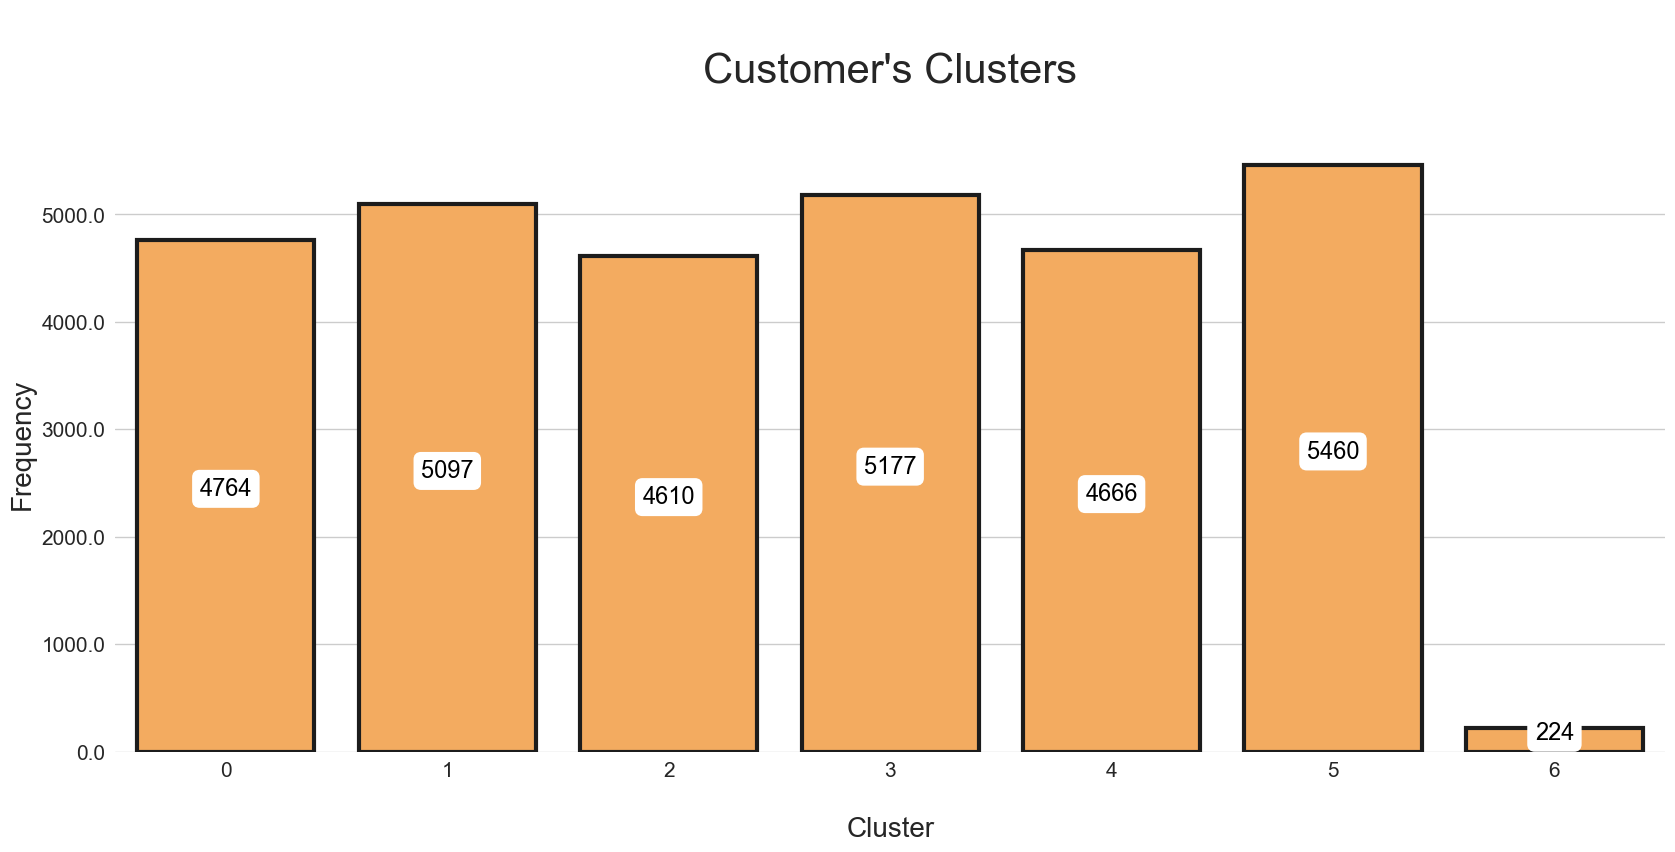

In [30]:
plot_clusters(info["cluster_kmeans_st"])

The output images shows a relatively uniform distribution among the clusters' sizes, with exception of cluster six.

To get insights on how well each cluster is defined, the `plot_silhouette` function is used.

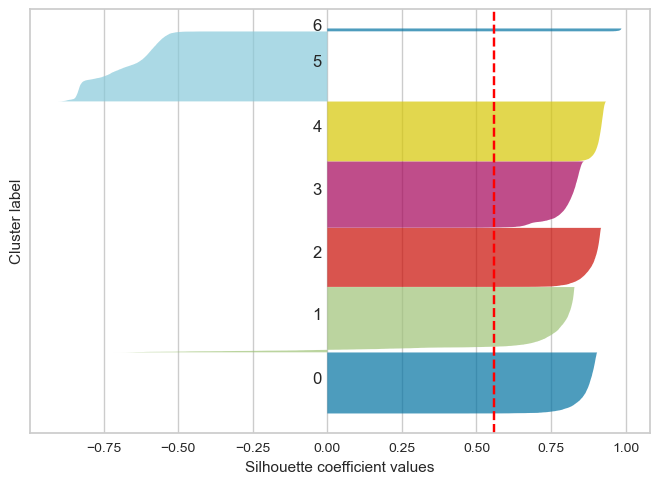

In [31]:
plot_silhouette(data_to_scale,kmeans_solution_st)

The output image above suggests that cluster five and part of cluster 1 are not well defined.

To have another indicator on the definition of each cluster, UMAP is used below, by applying the `umap_visual` function.

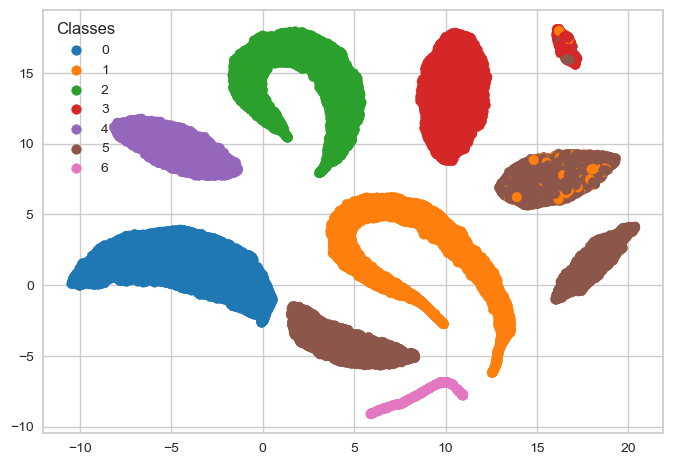

In [32]:
data_umap_st = info.drop(data_not_scaled.columns, axis=1).sort_index()
data_umap_st = data_umap_st.drop(["cluster_kmeans_st"], axis=1).sort_index()

embedding_st = umap_visual(data_umap_st, info["cluster_kmeans_st"].sort_index(), 15, 0.3, 42)

The output image indicated that clusters five, three and one are not well defined. However, they remaining appear to be well built.

The information about each cluster size is stored in 'kmeans_size_st' for future comparisons.

In [33]:
kmeans_size_st = info.groupby("cluster_kmeans_st").size().to_frame()
kmeans_size_st.columns = ["kmeans_size_st"]

The results provided by this clustering technique will also be removed from the 'info' data set in the next cell, for the reasons previously stated, for the other techniques.

In [34]:
info = info.drop("cluster_kmeans_st",axis =1)

#### **3.2 Hierarchical DBSCAN**

To seek better performing clusters from the outputs of K-means, Hierarchical DBSCAN (HDBSCAN) is used on the UMAP of the K-means.

Hierarchical DBSCAN is a variant of DBSCAN that uses a dendrogram to represent the hierarchy of clusters. It combines clusters based on density connectivity, accommodating multiple density and shape clusters. It allows flexible and robust clustering, discovering clusters at different levels of granularity in the data.

To create the HDBSCAN clusters, it is used the `hdbscan.HDBSCAN` function with `min_samples = 10` and `min_cluster_size = 200`. This first parameter, `min_samples`, was previously described, and  `min_cluster_size`, as the name suggests, corresponds to the minimum number of observations that can form a cluster. If a group of observations cannot be a part of a cluster with the minimum cluster size, they are considered outliers. The values for these two parameters were selected after some trials.

It is also used `fit_predict` to fit the values stored in `embedding_mm`, which is the result of the UMAP applied to the K-means clusters, and predict the cluster for each observation. 

##### **A. Using MinMax scaler**

The described execution of the HDBSCAN is conducted for the MinMax scaled data and stored in the column 'cluster_kmeans_hdbscan_mm' of the 'info' data set.

In [35]:
info['cluster_kmeans_hdbscan_mm'] = hdbscan.HDBSCAN(min_samples=10,min_cluster_size=200).fit_predict(embedding_mm)

To visualize the distribution of the HDBSCAN clusters, it is used the function `plot_clusters`.

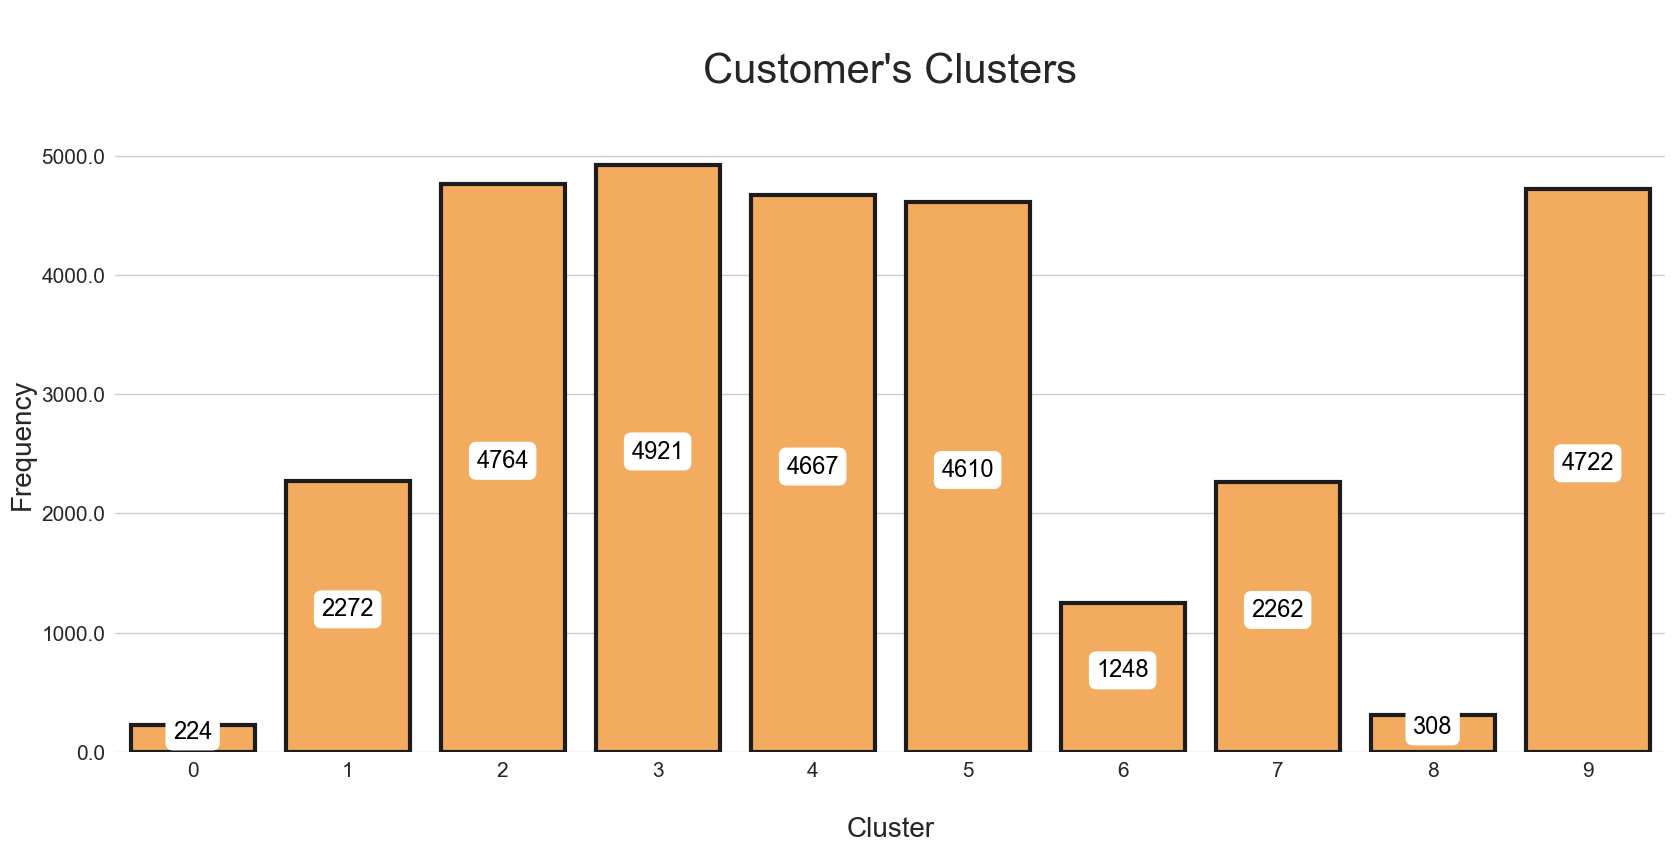

In [36]:
plot_clusters(info["cluster_kmeans_hdbscan_mm"])

The output displays a variation of cluster's sizes, and, contrarily to the original K-means on MinMax scaled data, there is not a cluster that carries at least one thounsand more observations than all the remaing ones. 

As a final visualization, the UMAP is used to access the definition of each cluster. 

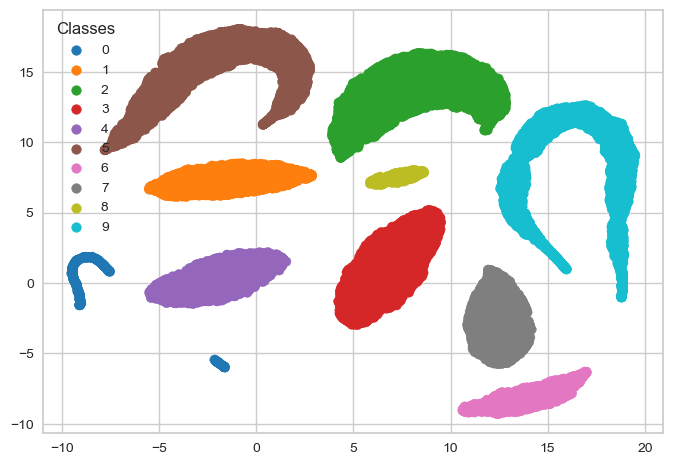

In [37]:
_ = umap_visual(data_umap, info['cluster_kmeans_hdbscan_mm'].sort_index(), 15, 0.3, 42)

The output image shows very sharply defined clusters. Cluster zero appears to be dispersed, however, when looking at the previous UMAP representations, cluster zero appears to be a closed cluster with small intra-cluster distances. Each UMAP representation may be slightly different, although it features the same distribution.

Similarly to the UMAP, the HDBSCAN at each iteration provides the same clusters, but in different order, e.g., in the first iteration the cluster of size 4610 may be assign to cluster five and in the second iteration to cluster three. Hence, the function `hdbscan_ordered` is used. This function receives as input the data, 'info', and the column where the cluster is supposed to be stored in the data and it returnes the data with the HDBSCAN clusters stored in ascendent order, i.e., the cluster with the smaller size is cluster zero, and the one with the largest size is nine. 

In [38]:
info = hdbscan_ordered(info, "cluster_kmeans_hdbscan_mm")
cluster_kmeans_hdbscan_mm = info['cluster_kmeans_hdbscan_mm'] 

To check if the previous function worked correctly, it is used the function `plot_clusters`.

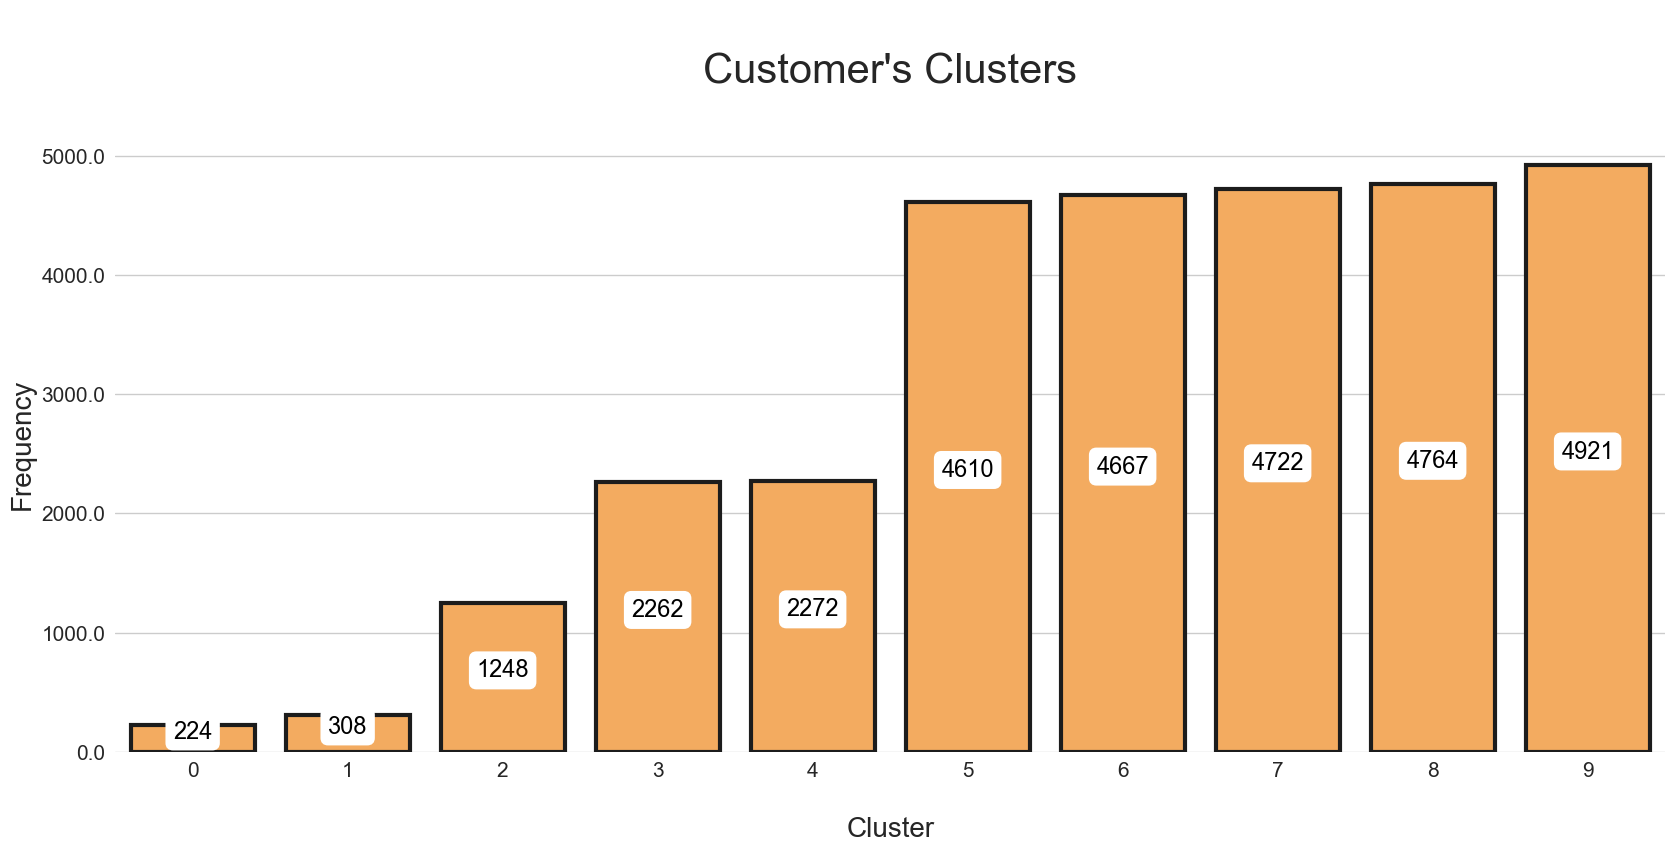

In [39]:
plot_clusters(info["cluster_kmeans_hdbscan_mm"])

The image above displays the cluster sizes in ascendent order, which means that the implementation of `hdbscan_ordered` was successful.

To check in further detail, the UMAP is performed for the ordered clusters. 

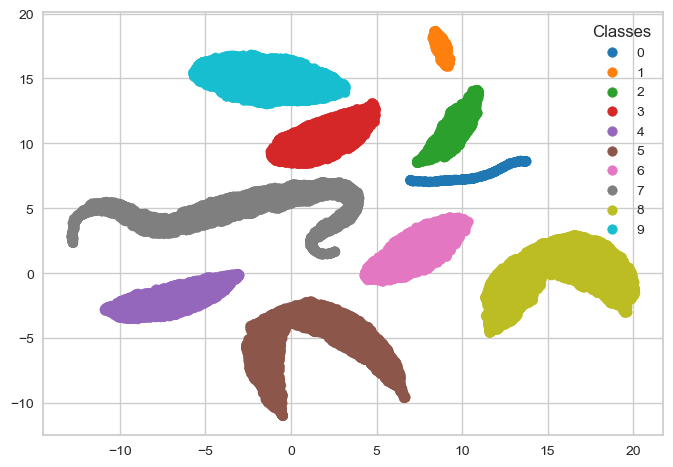

In [40]:
_ = umap_visual(data_umap, info['cluster_kmeans_hdbscan_mm'].sort_index(), 15, 0.3, 42)

When comparing the output image above with the representation of the UMAP for the non ordered HDBSCAN clusters, it is evident that the clusters are consistent, having only changed their numerical representation. It is also observed that cluster zero did not change, as it is the one with the smallest cluster size, and in this representation it is not dispersed. This last statement may not be true in different runs, as the initial cluster zero may not contain the smallest sized cluster. 

After checking the ordered HDBSCAN, the cluster sizes are stored in 'kmeans_hdbscan_size_mm' for further comparisons.

In [41]:
kmeans_hdbscan_size_mm = info.groupby("cluster_kmeans_hdbscan_mm").size().to_frame()
kmeans_hdbscan_size_mm.columns = ["kmeans_hdbscan_size_mm"]

Subsquently, the column with the HDBSCAN clusters is removed from 'info' not to cause errors with other implementations. 

In [42]:
info = info.drop("cluster_kmeans_hdbscan_mm", axis = 1)

##### **B. Using standard scaler**

The described execution of the HDBSCAN is conducted for the standard scaled data and stored in the column 'cluster_kmeans_hdbscan_st' of the 'info' data set.

In [43]:
info['cluster_kmeans_hdbscan_st'] = hdbscan.HDBSCAN(min_samples=10,min_cluster_size=200).fit_predict(embedding_st)

To visualize the distribution of the HDBScan clusters, it is used the function `plot_clusters`.

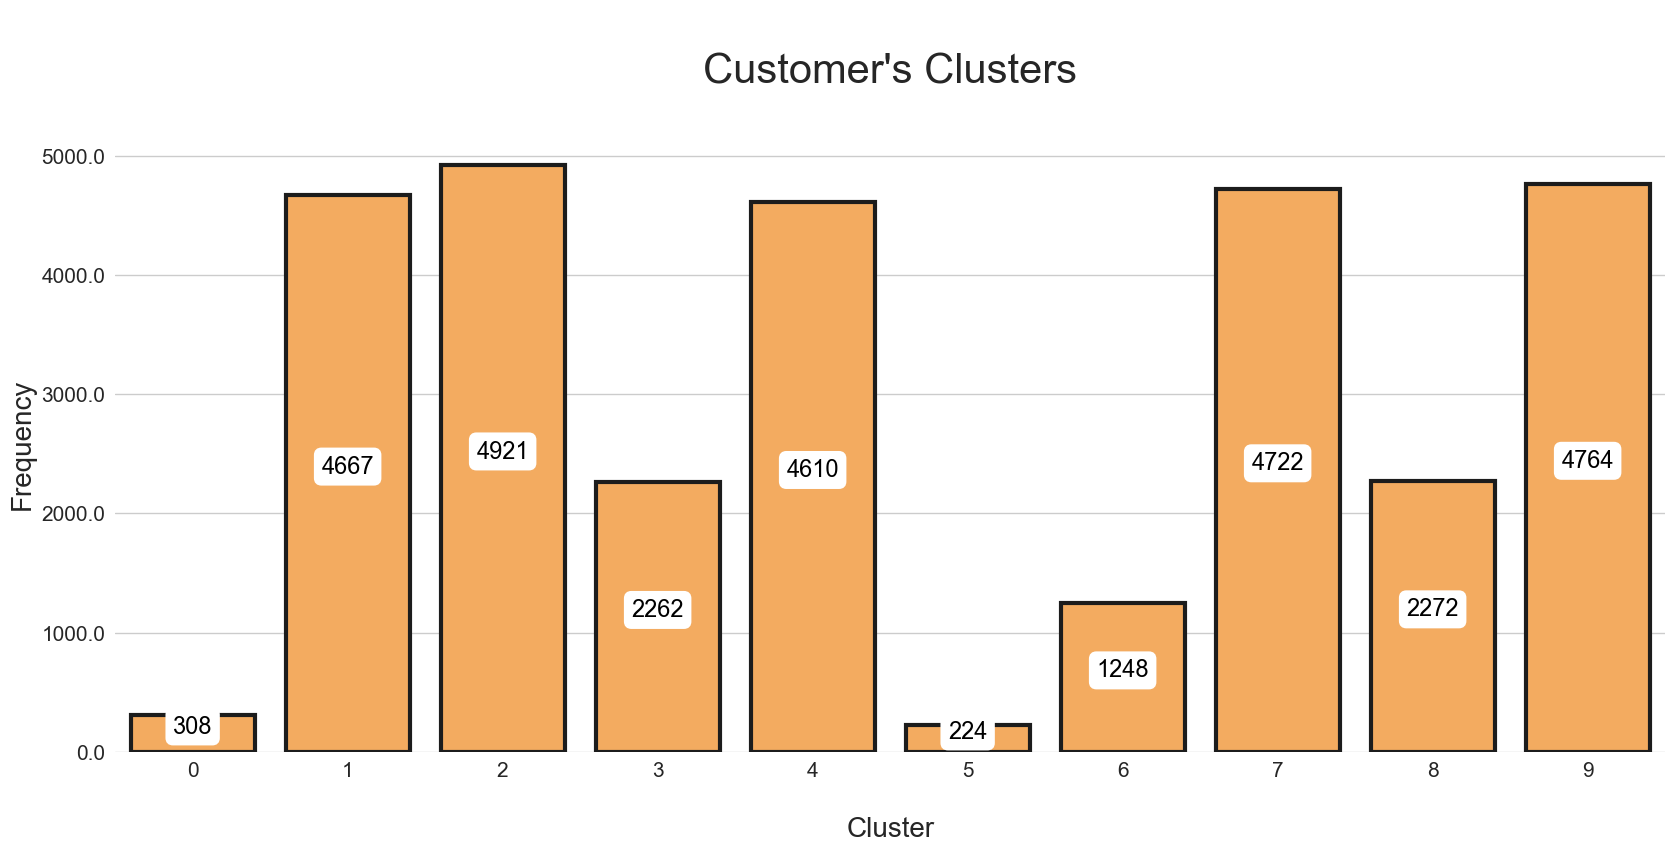

In [44]:
plot_clusters(info["cluster_kmeans_hdbscan_st"])

The output displays a variation of cluster's sizes, and, they seem quite similar to the ones that resulted from the implementation with MinMax scaled data. 

As a final visualization, the UMAP is used to access the definition of each cluster. 

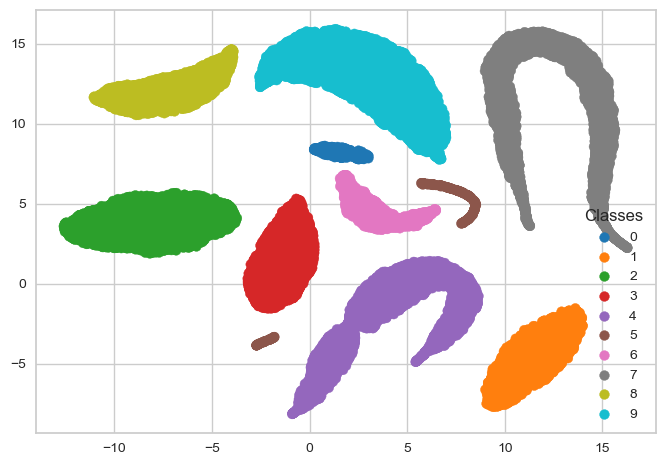

In [45]:
_ = umap_visual(data_umap, info['cluster_kmeans_hdbscan_st'].sort_index(), 15, 0.3, 42)

The output image shows very sharply defined clusters. Cluster zero appears to be dispersed, however, when looking at the previous UMAP representations, cluster zero appears to be a closed cluster with small intra-cluster distances. AS previously mentioned, each UMAP representation may be slightly different, although it features the same distribution.

The `hdbscan_ordered` is used for the standard scaled data, for the same reasons described for the MinMax scaled data. 

In [46]:
info = hdbscan_ordered(info, "cluster_kmeans_hdbscan_st")
cluster_kmeans_hdbscan_st = info['cluster_kmeans_hdbscan_st'] 

To check if the previous function worked correctly, it is used the function `plot_clusters`.

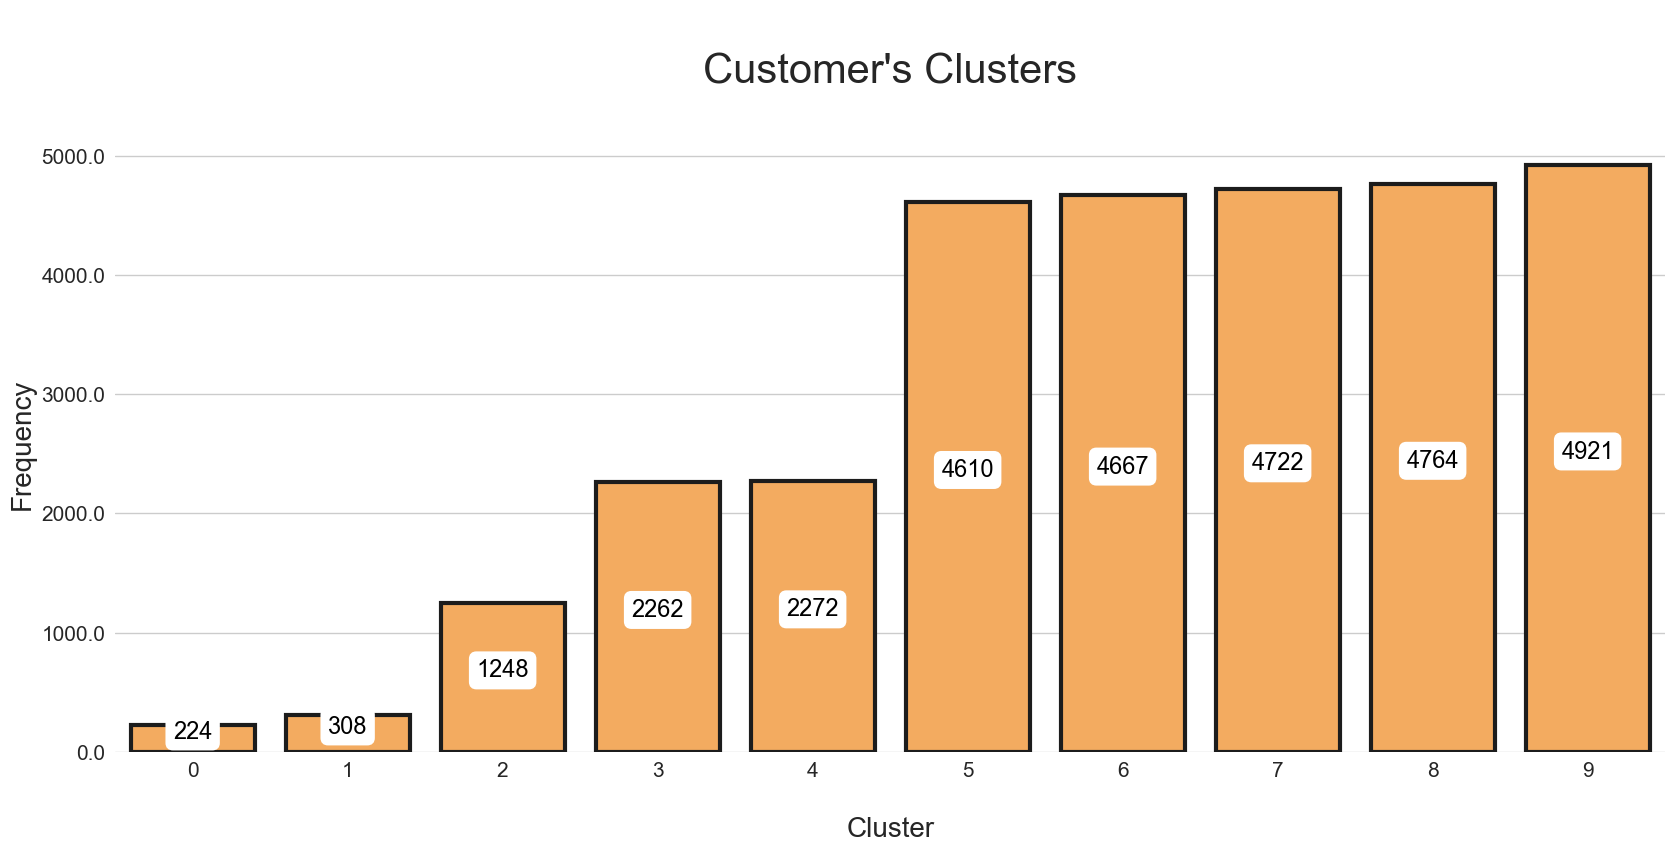

In [47]:
plot_clusters(info["cluster_kmeans_hdbscan_st"])

The image above displays the cluster sizes in ascendent order, which means that the implementation of `hdbscan_ordered` was successful. With this visualization, it is noted that the cluster sizes are exactly as same as the ones provided by the implementation with the MinMax scaled data.

To check in further detail, the UMAP is performed for the ordered clusters. 

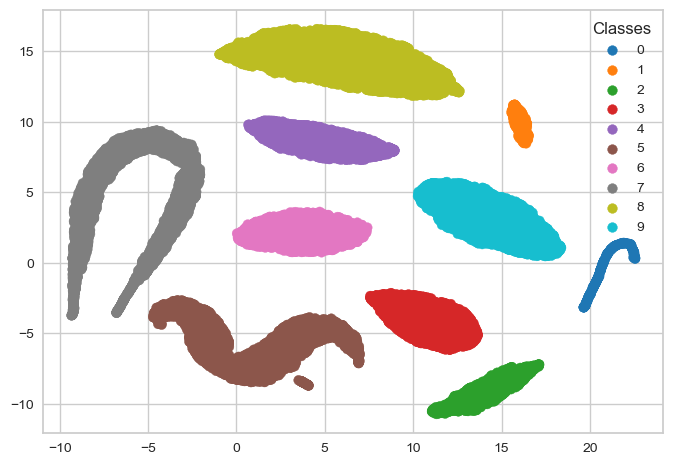

In [48]:
_ = umap_visual(data_umap, info['cluster_kmeans_hdbscan_st'].sort_index(), 15, 0.3, 42)

When comparing the output image above with the representation of the UMAP for the non ordered HDBSCAN clusters, it is evident that the clusters are consistent, having only changed their numerical representation. It is also observed that the cluster with 224 observations is not dispersed in this representation, contrarily to the cluster of size 4610 (initial cluster four, and cluster five after ordering) which in the not ordered UMAP clusters appeared to be closed and in this representation is slightly dispersed. 

After checking the ordered HDBSCAN, the cluster sizes are stored in 'kmeans_hdbscan_size_st' for further comparisons.

In [49]:
kmeans_hdbscan_size_st = info.groupby("cluster_kmeans_hdbscan_st").size().to_frame()
kmeans_hdbscan_size_st.columns = ["kmeans_hdbscan_size_st"]

Subsquently, the column with the HDBScan clusters is removed from 'info' not to cause errors with other implementations. 

In [50]:
info = info.drop(['cluster_kmeans_hdbscan_st'], axis =1)

<br><br>

### **Cluster size comparison**

To compare the different clustering implementations conducted, the cluster sizes from each implementation is diplayed in a daframe. 

In [51]:
pd.concat([dbscan_size, fmc_size, kmeans_size_st, kmeans_size_mm, kmeans_hdbscan_size_st, kmeans_hdbscan_size_mm],axis = 1, sort = False)

,dbscan_size,fmc_size,kmeans_size_st,kmeans_size_mm,kmeans_hdbscan_size_st,kmeans_hdbscan_size_mm
-1,9.0,NaN,NaN,NaN,NaN,NaN
0,10748.0,4610.0,4764.0,4667.0,224.0,224.0
1,4610.0,5377.0,5097.0,4921.0,308.0,308.0
2,4921.0,5411.0,4610.0,4740.0,1248.0,1248.0
3,4722.0,4764.0,5177.0,4610.0,2262.0,2262.0
4,4764.0,5176.0,4666.0,4764.0,2272.0,2272.0
5,224.0,4660.0,5460.0,6296.0,4610.0,4610.0
6,NaN,NaN,224.0,NaN,4667.0,4667.0
7,NaN,NaN,NaN,NaN,4722.0,4722.0
8,NaN,NaN,NaN,NaN,4764.0,4764.0


It is observed that the only clustering technique detecting outliers was the BDScan, which detected nine. It can also be noted that there are certain cluster sizes quite common throughout the different techniques, such as 4610.0 and 4764.0 (present in all implementations), and 224.0 (solely not present in FMC and k-means with MinMax scaled data).

<br><br>


### **Clustering technique selection**

The best clustering techniques were namely those provided by HDBSCAN, in which K-means and UMAP were used. There were two implementations of this technique, one with MinMax scaled data and one with standard scaled data. These two implementations provided equal results, i.e., the same clusters. Therefore, the choice between the two was random, selecting the one with the MinMax scaler.

In the code below, the mentioned HDBSCAN implementation is defined in 'info' as the data's cluster. 

In [52]:
info["cluster"] = cluster_kmeans_hdbscan_mm

<br><br>

## **Cluster analysis**

Having defined the clusters, it is important to understand what each cluster represents. 

To do this, the first step taken is the creation of a dataframe, 'cluster_means', which contains the average value of the features used for the clustering for each cluster. This dataframe will also be used in further sections.

In [53]:
cluster_means = info.drop(data_not_scaled, axis=1).groupby('cluster').mean()

The second step is to create a dataframe containing the average values of the population for each feature used in clustering, 'population_mean', and adding that dataframe to 'cluster_means', forming 'cluster_means_with_pop'. 

In [54]:
population_mean = info.drop(list(data_not_scaled) + ['cluster'], axis=1).mean()

cluster_means_with_pop = cluster_means.append(population_mean, ignore_index=True)

# storing the names of the rows in a dictionary named 'new_row_names'
new_row_names = dict(
    [(cluster_number, f'cluster {cluster_number}') for cluster_number in range(10)] +
    [(10, 'Population')]
)

# setting the name of the rows to 'new_row_names'
cluster_means_with_pop = cluster_means_with_pop.rename(index=new_row_names)

The dataframe 'cluster_means_with_pop' can be used to compare the mean values of each cluster for the respective columns and the population averages. Thus, the clusters will be characterized based on their mean values when comparing to the population. That process will be conducted below, following the visualization of the mentioned dataframe.

In [55]:
cluster_means_with_pop 

,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,lifetime_spend_alcohol_drinks,lifetime_spend_meat,lifetime_spend_fish,lifetime_spend_hygiene,lifetime_spend_videogames,lifetime_total_distinct_products,percentage_of_products_bought_promotion,years_as_customer,customer_age,num_kids,total_spend
cluster 0,0.000000,1.000000,2.701888,1.149657,0.625775,2.124256,2.302029,2.704794,2.616000,34999.035714,1.553728,0.000000,0.978300,0.200193,12.977679,50.566964,0.000000,35014.188067
cluster 1,4.139610,1.000000,199.211039,9.948052,10.048701,100.224026,99.925325,296.506494,49.402597,51.175325,49.707792,0.000000,100.538961,0.199909,13.256494,71.399351,1.022727,856.100649
cluster 2,0.000000,2.000000,100.346955,19.899038,21.606571,20.133814,199.929487,900.553686,49.848558,49.891026,49.731571,100.166667,79.710737,0.199982,6.100962,22.994391,0.016026,1490.500801
cluster 3,0.496021,2.011494,617.420866,611.014589,13.907162,302.609637,302.498674,298.152962,199.534925,199.086207,50.158267,199.990274,58.268789,0.100307,13.029178,52.390363,1.029178,2780.466401
cluster 4,0.018486,3.009683,6998.608715,1002.705986,18.956426,402.549736,400.469190,402.982394,699.633363,699.194542,200.338908,502.893926,502.506162,0.149835,13.072623,29.517606,0.162852,11309.376761
cluster 5,0.500000,1.992625,200.406291,4999.557484,20.951844,20.033623,1500.946855,499.866161,57.739913,58.946421,49.912148,2002.197397,99.785249,0.100002,13.021909,56.326247,0.758134,9389.606291
cluster 6,0.933576,3.007285,4997.018856,200.006642,17.401971,602.098779,900.787872,500.900364,1100.662738,1101.494750,500.748018,997.704307,2001.371759,0.200119,13.051639,56.162846,4.890508,10901.422327
cluster 7,0.310885,2.000212,997.551461,50.036637,9.988564,1499.739094,20.005294,20.117535,0.000000,0.000000,100.033037,49.929691,199.708598,0.049988,12.985176,55.980940,1.932020,2737.412749
cluster 8,1.551008,7.999580,14993.307935,199.970403,11.914568,799.560034,900.786104,599.145886,1501.016583,1498.781276,199.985306,50.012804,4011.462636,0.149955,22.993493,56.219563,1.269521,20742.566331
cluster 9,1.010567,20.001829,302.959764,20.000000,8.991668,300.231863,300.431823,199.776671,151.107702,149.465962,50.032514,5.000000,499.575493,0.499966,12.980492,55.883763,1.070108,1479.006300


By the visualization of the dataframe above it is possible to characterize the cluster in the following way:

<br>

Cluster 0 - fish enthusiasts: 
- Do not complain, do not have children and only visit one store at approximately midnight. 
- Almost no expenses at the different sections, except for fish. They spend significantly more in fish than every other customer.

<br>

Cluster 1 - old and crancky:
- Customers that have made the most complains, only visit one store and usually spend less than the average customers, having lowest amount of total expenses.
- The oldest customers, with an average age of 71 years.

<br>

Cluster 2 - young drunk:
- Do not complain, visit on average two stores at approximately 10 pm and usually have no kids.
- The youngest customers, with an average age of 23, and are the ones that spend the most in alcoholic drinks.

<br>

Cluster 3 - Not even average:
- Are below average in all features, in some of them close to average
- Have on average one child and 52 years.

<br>

Cluster 4 - Millennials:
- Almost no complains, visit on average three stores at aproximately 6 pm.
- They have on average 29 years, and belong to the second cluster with the higher groceries and total expenses.

<br>

Cluster 5 - Gamers:
- Do not complain, or do it only once, visit an average of two stores at approximately 9 pm, and have on average one child.
- Customers that spend the most in eletronics, videogames and non-alcoholic drinks (most likely energetic drinks).

<br>

Cluster 6 - Parents:
- Complain on average once, spend above average on most categories, including groceries, vegetables, alcoholic drinks and eventually total expenses.
- Have on average 56 years and four children, which is the highest average children for a cluster.

<br>

Cluster 7 - Vegetarians:
- Almost no complains, visit on average two stores at 10 am and have 55 years and two kids. 
- Do not spend any money on meat or fish, and are the ones who spend the most on vegetables, and purchase the least amount of products in promotion.

<br>

Cluster 8 - The heart of the company:
- Complain once or twice, visit on average eight stores at 12 am.
- Are the ones that have been customers for the longest time (on average 22 years), and spend the most in total and in categories such as groceries and meat.

<br>

Cluster 9 - promotion seekers:
- Visit on average one store and spent below average in all categories. 
- Are the customers that purchase the largest portion of products in promotion (approximately 50%).

<br><br>

### **Cluster integration**

At the beginning of this notebook, two observations were set aside, specifically those that had missing values at the typical hour column. These observations will now undergo the process of finding their most suitable cluster.



In [56]:
missing_typical_hour

,customer_id,customer_name,customer_gender,number_complaints,distinct_stores_visited,lifetime_spend_groceries,lifetime_spend_electronics,typical_hour,lifetime_spend_vegetables,lifetime_spend_nonalcohol_drinks,...,percentage_of_products_bought_promotion,latitude,longitude,years_as_customer,customer_age,education,has_child,has_loyalty_card,num_kids,total_spend
12774,8592,Charles`s Supermarket,male,0.0,1.0,2.64414,1.130447,NaN,2.135861,2.318517,...,0.196409,38.866685,-9.111366,10.0,35,basic,0,0,0.0,35020.089664
23915,101,Annie`s Supermarket,female,0.0,1.0,2.65918,1.133150,NaN,2.090952,2.297560,...,0.194451,38.866048,-9.111718,14.0,76,basic,0,1,0.0,34717.045827


The two observations are very similar to the ones in cluster zero as such we added them into the dataset with cluster zero as their cluster. The similarities are in the fact they have a the same last name and they do not have complains nor kids and spend a enormous amount on fish and almost none on other products.

In [57]:
missing_typical_hour["typical_hour"] = info[info["cluster"]==0]["typical_hour"].mean()
missing_typical_hour["cluster"] = 0

The two elements that had the anomaly in typical_hour, are part of the cluster zero (fish enthusiasts) and as such their typical_hour value as inputed with the cluster mean value.

In [58]:
info = info.append(missing_typical_hour, ignore_index=True)

<br><br>

## **Export**
The data on cluster means is now exported as a csv file, named 'cluster_means'.

In [59]:
cluster_means.to_csv(path+"cluster_means.csv", index = False)

The transformed data, with the defined cluster values is now exported as a csv file, named 'cluster_info.csv'.

In [60]:
info.to_csv(path+"cluster_info.csv", index=False)